Introduction

In this notebook, we evaluate the fine-tuned Transformer model on the Yelp Review dataset.
We compute standard classification metrics and analyze model performance using a confusion matrix.

Evaluation Metrics:

Precision

Recall

F1-score

Confusion Matrix

Environment & Imports

In [ ]:
import os
import numpy as np
import torch
import pandas as pd

from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

import matplotlib.pyplot as plt
import seaborn as sns

print("Evaluation environment ready")
print("Torch version:", torch.__version__)


C:\Users\Srinivasan\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluation environment ready ✅
Torch version: 2.9.1+cpu


3. Load Processed Dataset

We load the same processed test dataset used during training.

In [5]:
test_ds = load_from_disk("data/processed/test_clean")

print("Test dataset size:", len(test_ds))


Test dataset size: 50000


Load Tokenizer & Trained Model

In [ ]:
MODEL_PATH = "models/roberta_yelp/final"
MODEL_NAME = "roberta-base"
NUM_LABELS = 5

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

model = RobertaForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS
)

print("Model and tokenizer loaded successfully")


Model and tokenizer loaded ✅


Tokenize Test Dataset (Same as Training)

In [ ]:
def tokenize_function(batch):
    return tokenizer(
        batch["clean_text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

test_tokenized = test_ds.map(tokenize_function, batched=True)

test_tokenized = test_tokenized.remove_columns(["text", "clean_text"])
test_tokenized.set_format("torch")

print("Test data tokenized and formatted")

Test data tokenized ✅


Initialize Trainer for Evaluation Only

We reuse Trainer only for prediction.

In [ ]:
eval_args = TrainingArguments(
    output_dir="models/roberta_yelp/eval",
    per_device_eval_batch_size=8,
    report_to="none",
    no_cuda=True
)

trainer = Trainer(
    model=model,
    args=eval_args,
    tokenizer=tokenizer
)

print("Trainer ready for evaluation")


Trainer ready for evaluation ✅


C:\Users\Srinivasan\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
C:\Users\Srinivasan\AppData\Local\Temp\ipykernel_34520\2756821239.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Generate Predictions & Classification Report (Precision, Recall, F1)

In [ ]:
test_small = test_tokenized.shuffle(seed=42).select(range(1000))

print("Test samples used for evaluation:", len(test_small))

###predictions = trainer.predict(test_tokenized)

predictions = trainer.predict(test_small)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("Predictions generated")

class_names = ["1-star", "2-star", "3-star", "4-star", "5-star"]

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)

print("Classification Report:\n")
print(report)


Test samples used for evaluation: 1000


Predictions generated ✅
Classification Report:

              precision    recall  f1-score   support

      1-star     0.7500    0.7364    0.7431       220
      2-star     0.5307    0.5681    0.5488       213
      3-star     0.5613    0.6071    0.5833       196
      4-star     0.5677    0.5317    0.5491       205
      5-star     0.7303    0.6687    0.6981       166

    accuracy                         0.6220      1000
   macro avg     0.6280    0.6224    0.6245      1000
weighted avg     0.6257    0.6220    0.6232      1000



Overall Precision, Recall, F1 (Weighted)

In [10]:
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true,
    y_pred,
    average="weighted"
)

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print(f"Weighted F1-score:  {f1:.4f}")


Weighted Precision: 0.6257
Weighted Recall:    0.6220
Weighted F1-score:  0.6232


Confusion Matrix

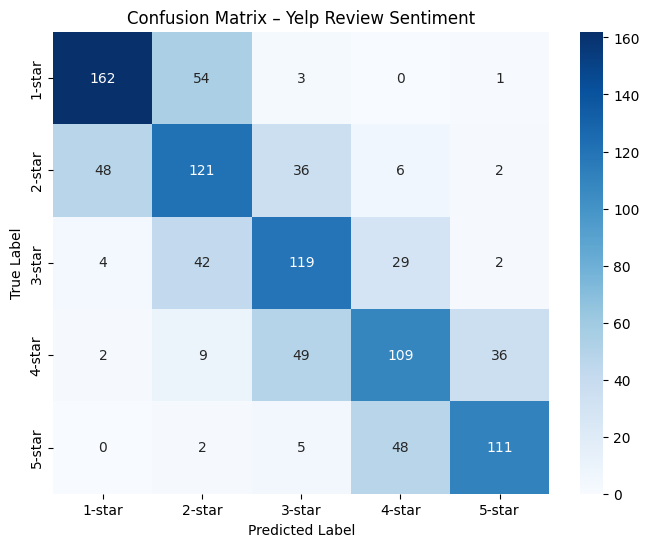

In [11]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Yelp Review Sentiment")
plt.show()


In [ ]:
Error Analysis

In [12]:
results_df = pd.DataFrame({
    "true_label": y_true,
    "predicted_label": y_pred
})

misclassified = results_df[results_df["true_label"] != results_df["predicted_label"]]

print("Number of misclassified samples:", len(misclassified))
misclassified.head()


Number of misclassified samples: 378


,true_label,predicted_label
0,2,3
1,4,3
2,1,0
4,3,2
10,0,1
